### Monthly Frequency

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness   eigenvector
^KS11      0.941176     0.042747  2.738798e-01
^GSPC      0.882353     0.015174  2.687848e-01
^FTSE      0.882353     0.027184  2.661639e-01
^AXJO      0.882353     0.015174  2.687848e-01
^GSPTSE    0.882353     0.015174  2.687848e-01
^GDAXI     0.823529     0.003287  2.610688e-01
^FCHI      0.823529     0.003287  2.610688e-01
^STOXX50E  0.823529     0.003287  2.610688e-01
^AEX       0.823529     0.003287  2.610688e-01
^IXIC      0.823529     0.003287  2.610688e-01
^BSESN     0.823529     0.030270  2.442392e-01
^DJI       0.823529     0.003287  2.610688e-01
^TWII      0.764706     0.016544  2.365233e-01
^MXX       0.705882     0.008578  2.214606e-01
^N225      0.647059     0.000000  2.131799e-01
^BVSP      0.352941     0.000613  1.131426e-01
^HSI       0.235294     0.000000  7.471019e-02
^TASI.SR   0.000000     0.000000  1.708094e-09

Community Memberships:
Community 1: ['^GSPC', '^IXIC', '^DJI', '^FTSE

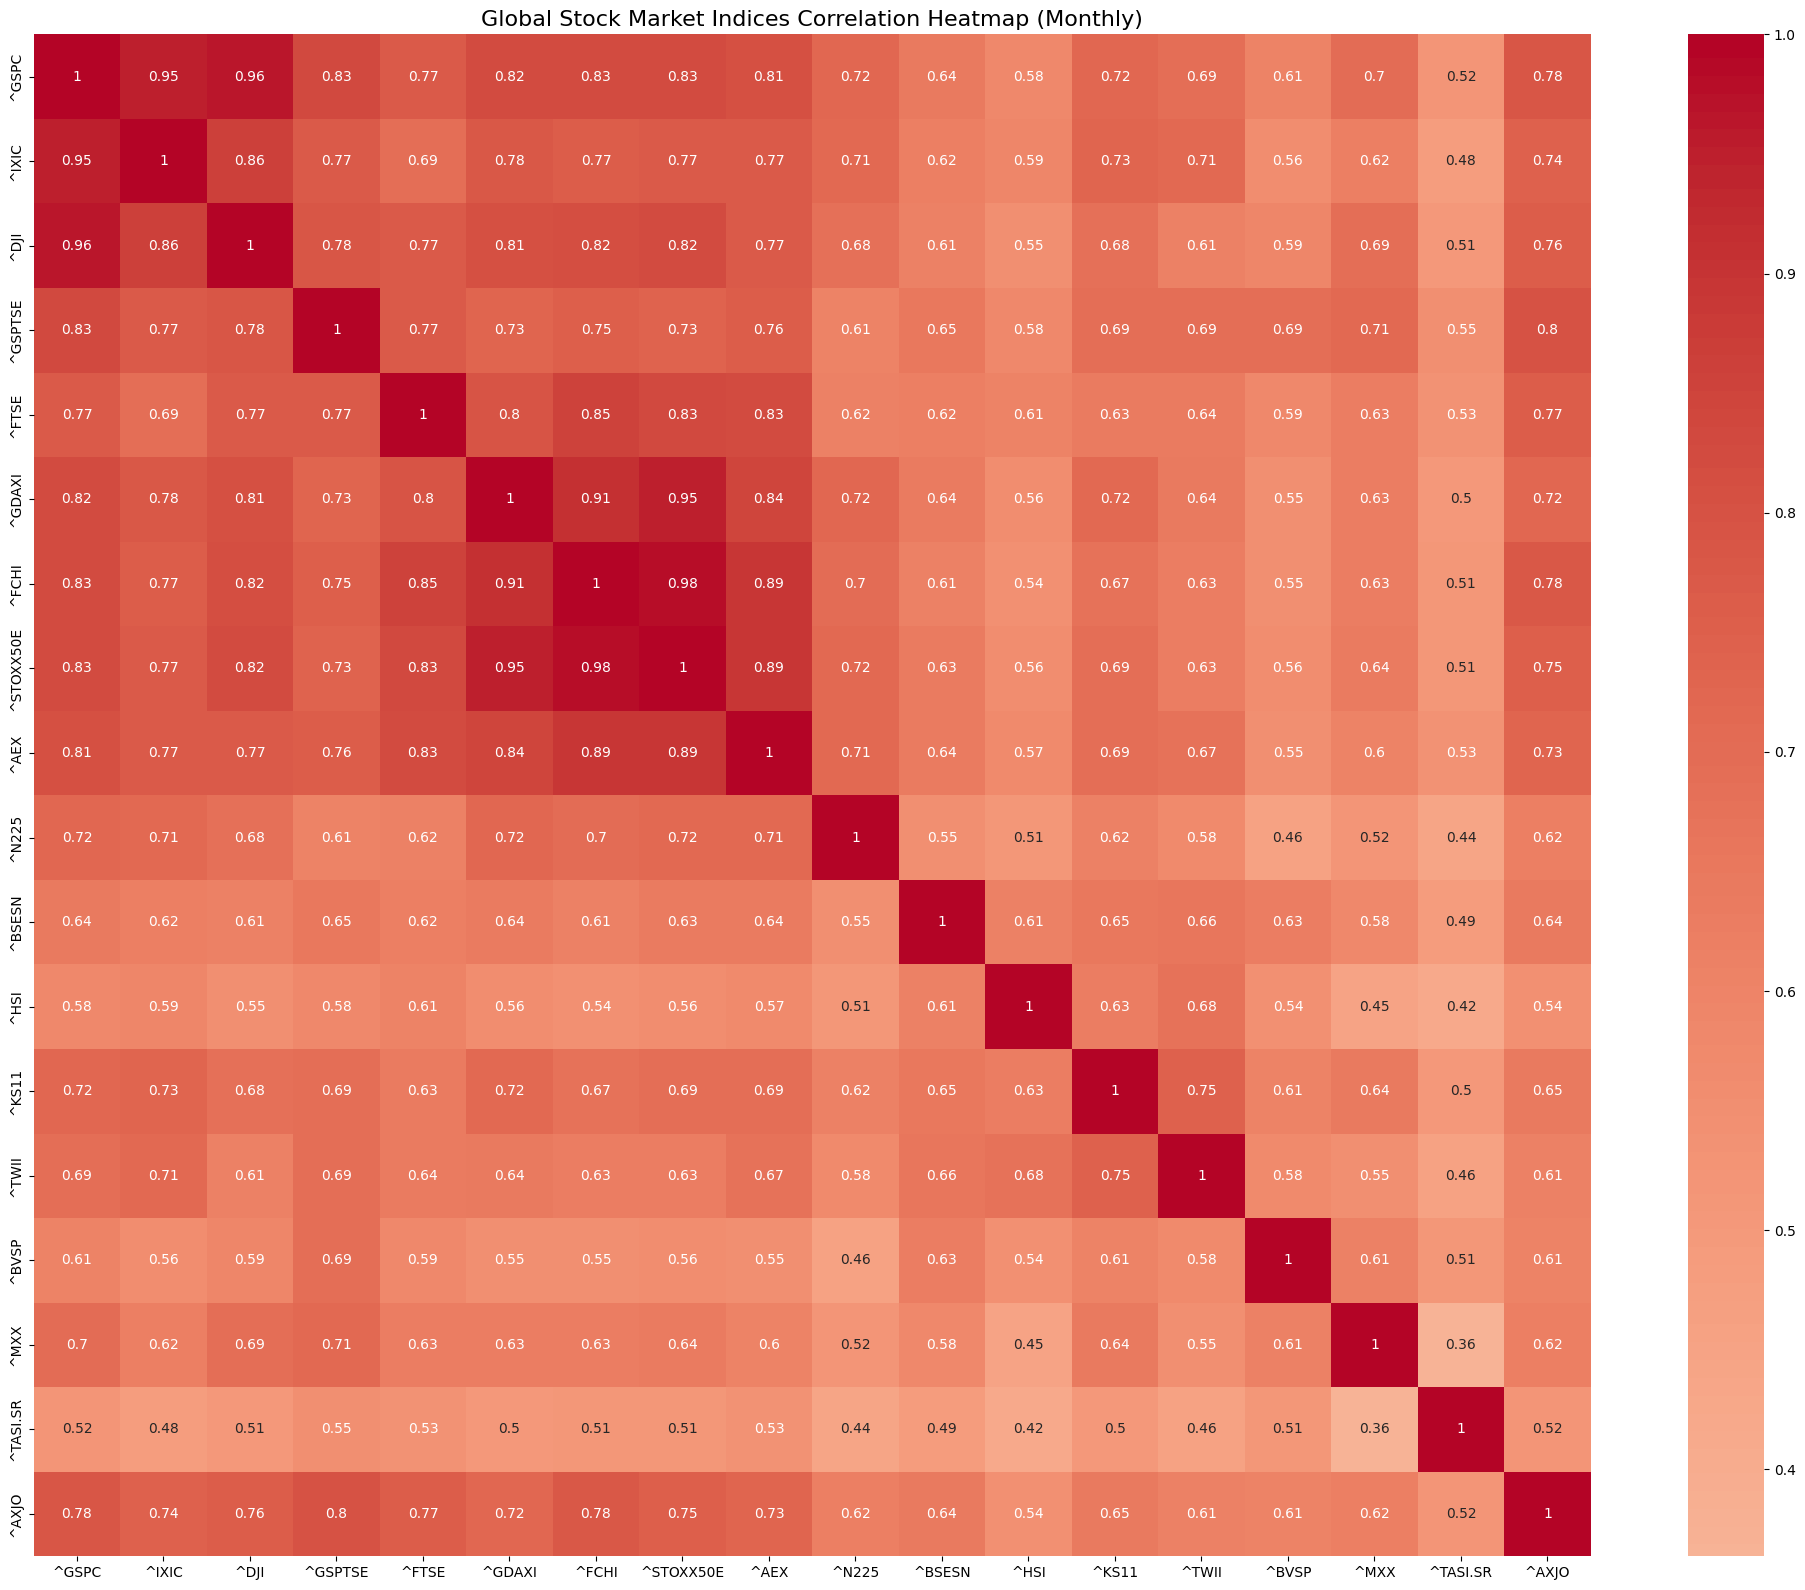

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency 
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(
                        self.tickers[i], 
                        self.tickers[j], 
                        weight=corr
                    )
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_monthly.png'):
        """
        Visualize the stock market network with community-based coloring.
        
        Parameters:
        - output_file: File to save network visualization
        """
        # Detect communities
        communities = self.detect_communities()

        if not communities:
            print("No communities detected.")
            return
        
        # Generate a color map for communities using light colors
        unique_communities = set(communities.values())
        light_colors = sns.color_palette("pastel", len(unique_communities))
        community_colors = {comm: light_colors[i] for i, comm in enumerate(unique_communities)}

        # Assign colors to nodes based on their community
        node_colors = [community_colors[communities[node]] for node in self.network.nodes()]

        # Create the network visualization
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes with colors based on community membership
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color=node_colors, 
            node_size=node_sizes,
            alpha=0.8
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network with Community-Based Coloring', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()
    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='ME')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap (Monthly)', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

### Weekly Frequency

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness   eigenvector
^KS11      0.941176     0.138235  2.858658e-01
^FTSE      0.823529     0.018137  2.784021e-01
^AEX       0.823529     0.018137  2.784021e-01
^GSPC      0.764706     0.002941  2.701003e-01
^STOXX50E  0.764706     0.002941  2.701003e-01
^IXIC      0.764706     0.002941  2.701003e-01
^N225      0.764706     0.031127  2.494480e-01
^FCHI      0.764706     0.002941  2.701003e-01
^GDAXI     0.764706     0.002941  2.701003e-01
^GSPTSE    0.764706     0.002941  2.701003e-01
^DJI       0.764706     0.002941  2.701003e-01
^AXJO      0.764706     0.031127  2.494480e-01
^BVSP      0.647059     0.000000  2.336771e-01
^MXX       0.647059     0.000000  2.336771e-01
^HSI       0.411765     0.022059  1.137101e-01
^TWII      0.235294     0.000000  7.076160e-02
^BSESN     0.117647     0.000000  3.146973e-02
^TASI.SR   0.000000     0.000000  1.098712e-12

Community Memberships:
Community 2: ['^GSPC', '^IXIC', '^DJI', '^GSPT

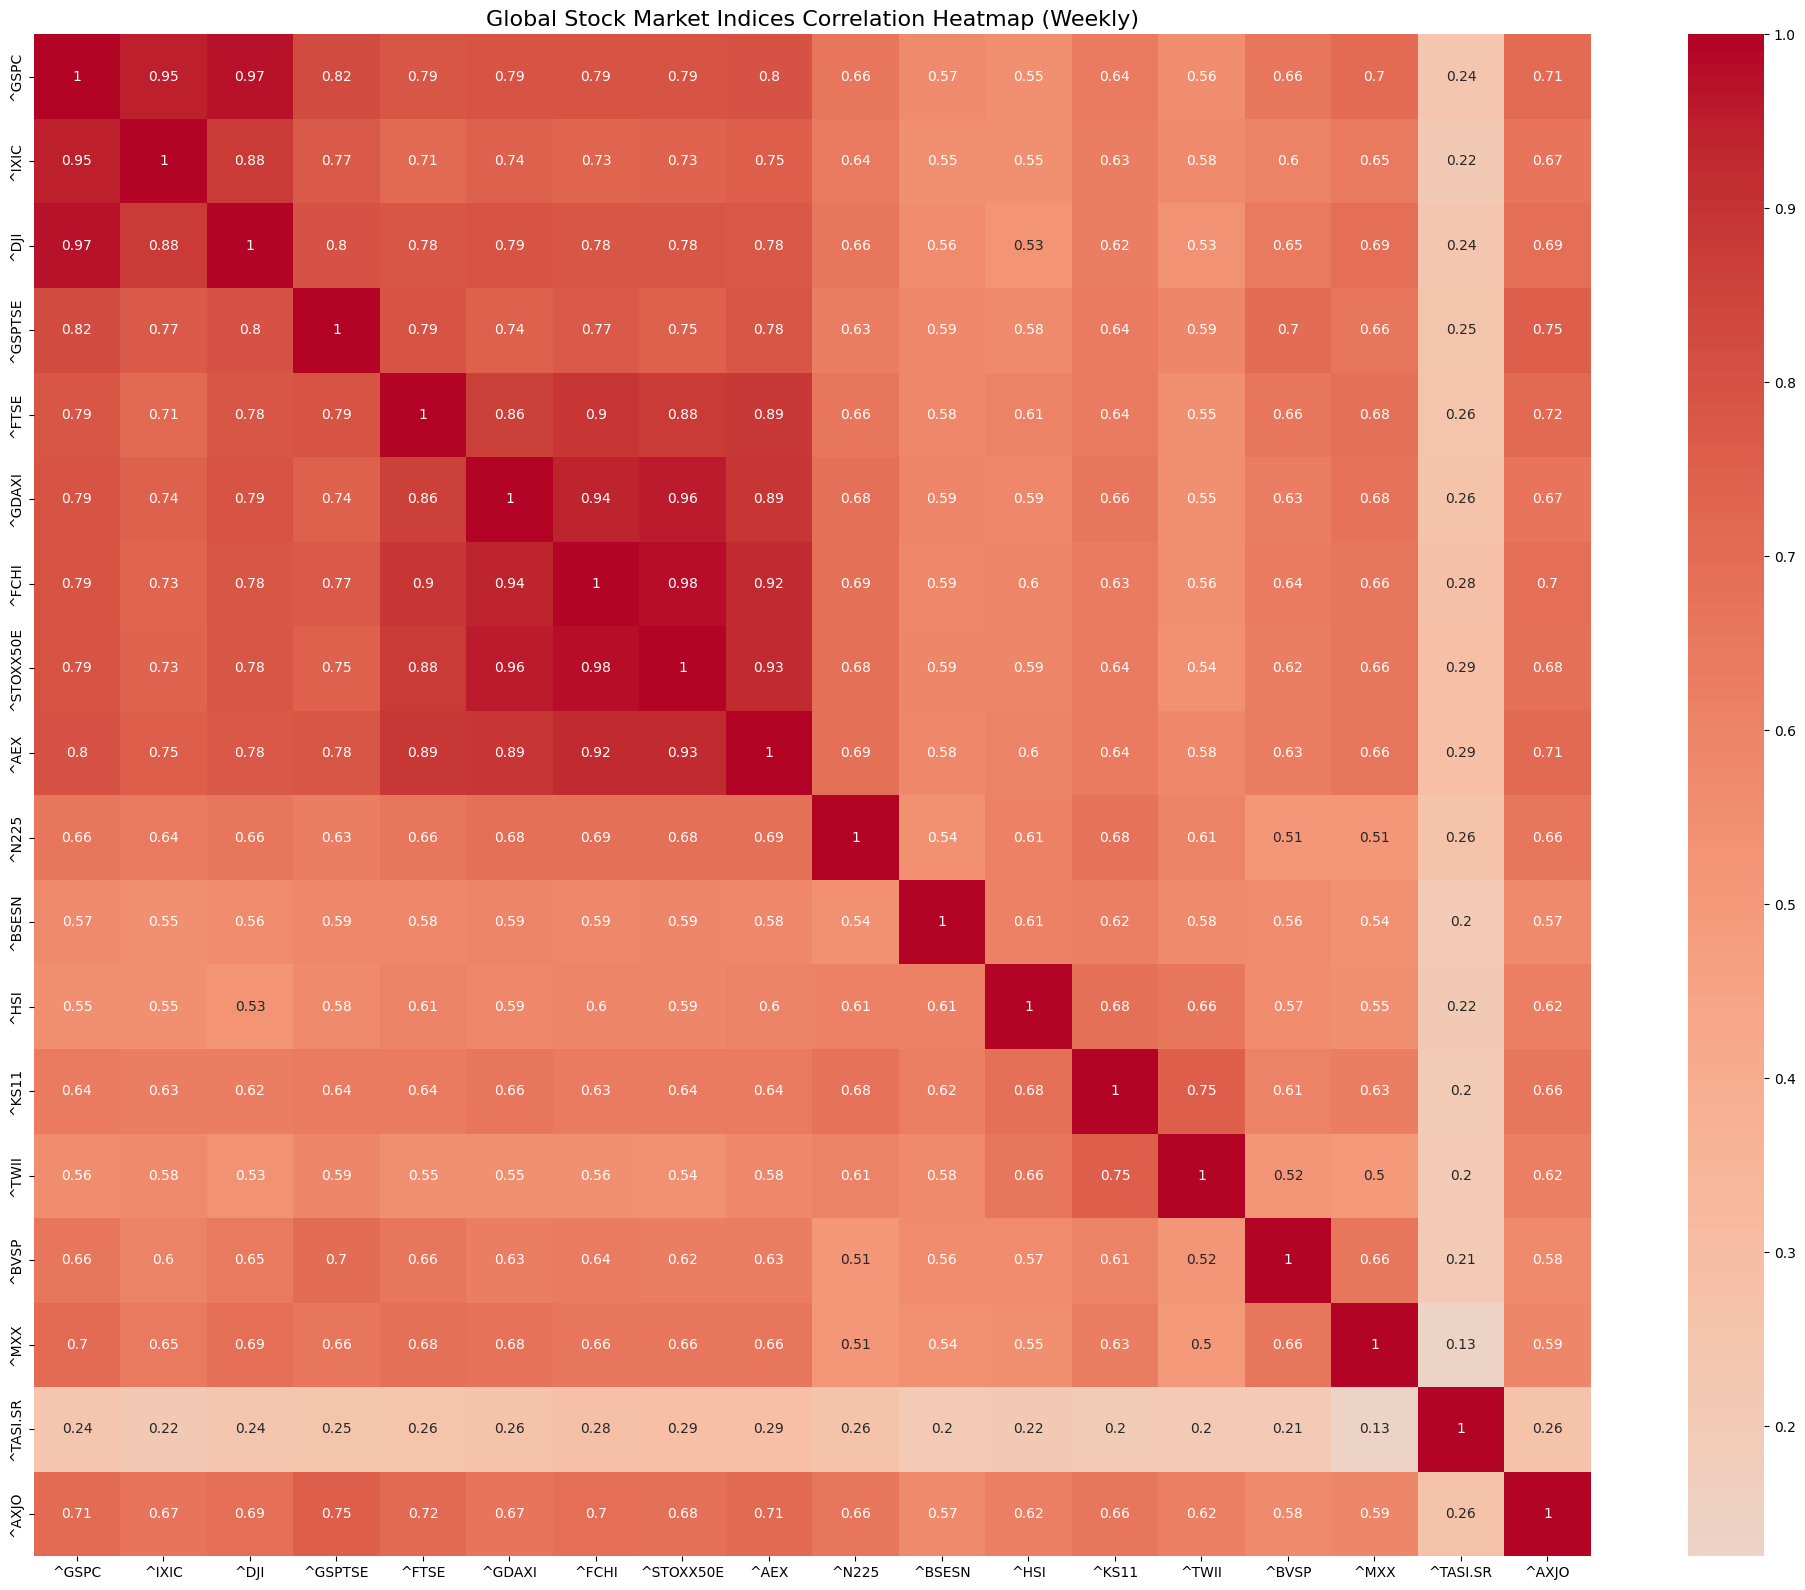

In [44]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(
                        self.tickers[i], 
                        self.tickers[j], 
                        weight=corr
                    )
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_Weekly.png'):
        """
        Visualize the stock market network.
        
        Parameters:
        - output_file: File to save network visualization
        """
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color='lightblue', 
            node_size=node_sizes,
            alpha=0.7
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network Interconnectedness (Weekly)', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()
    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='W')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap (Weekly)', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness  eigenvector
^GSPTSE    1.000000     0.073179     0.261703
^GSPC      0.941176     0.010679     0.259564
^AEX       0.941176     0.010679     0.259564
^TWII      0.941176     0.010679     0.259564
^KS11      0.941176     0.010679     0.259564
^IXIC      0.941176     0.010679     0.259564
^AXJO      0.941176     0.010679     0.259564
^STOXX50E  0.882353     0.003064     0.250721
^FCHI      0.882353     0.003064     0.250721
^GDAXI     0.882353     0.003064     0.250721
^BSESN     0.882353     0.053309     0.235250
^FTSE      0.882353     0.003064     0.250721
^DJI       0.882353     0.003064     0.250721
^HSI       0.764706     0.000000     0.224268
^MXX       0.705882     0.000000     0.208318
^N225      0.705882     0.000000     0.208318
^BVSP      0.470588     0.000000     0.139278
^TASI.SR   0.117647     0.000000     0.033692

Community Memberships:
Community 0: ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^FCHI

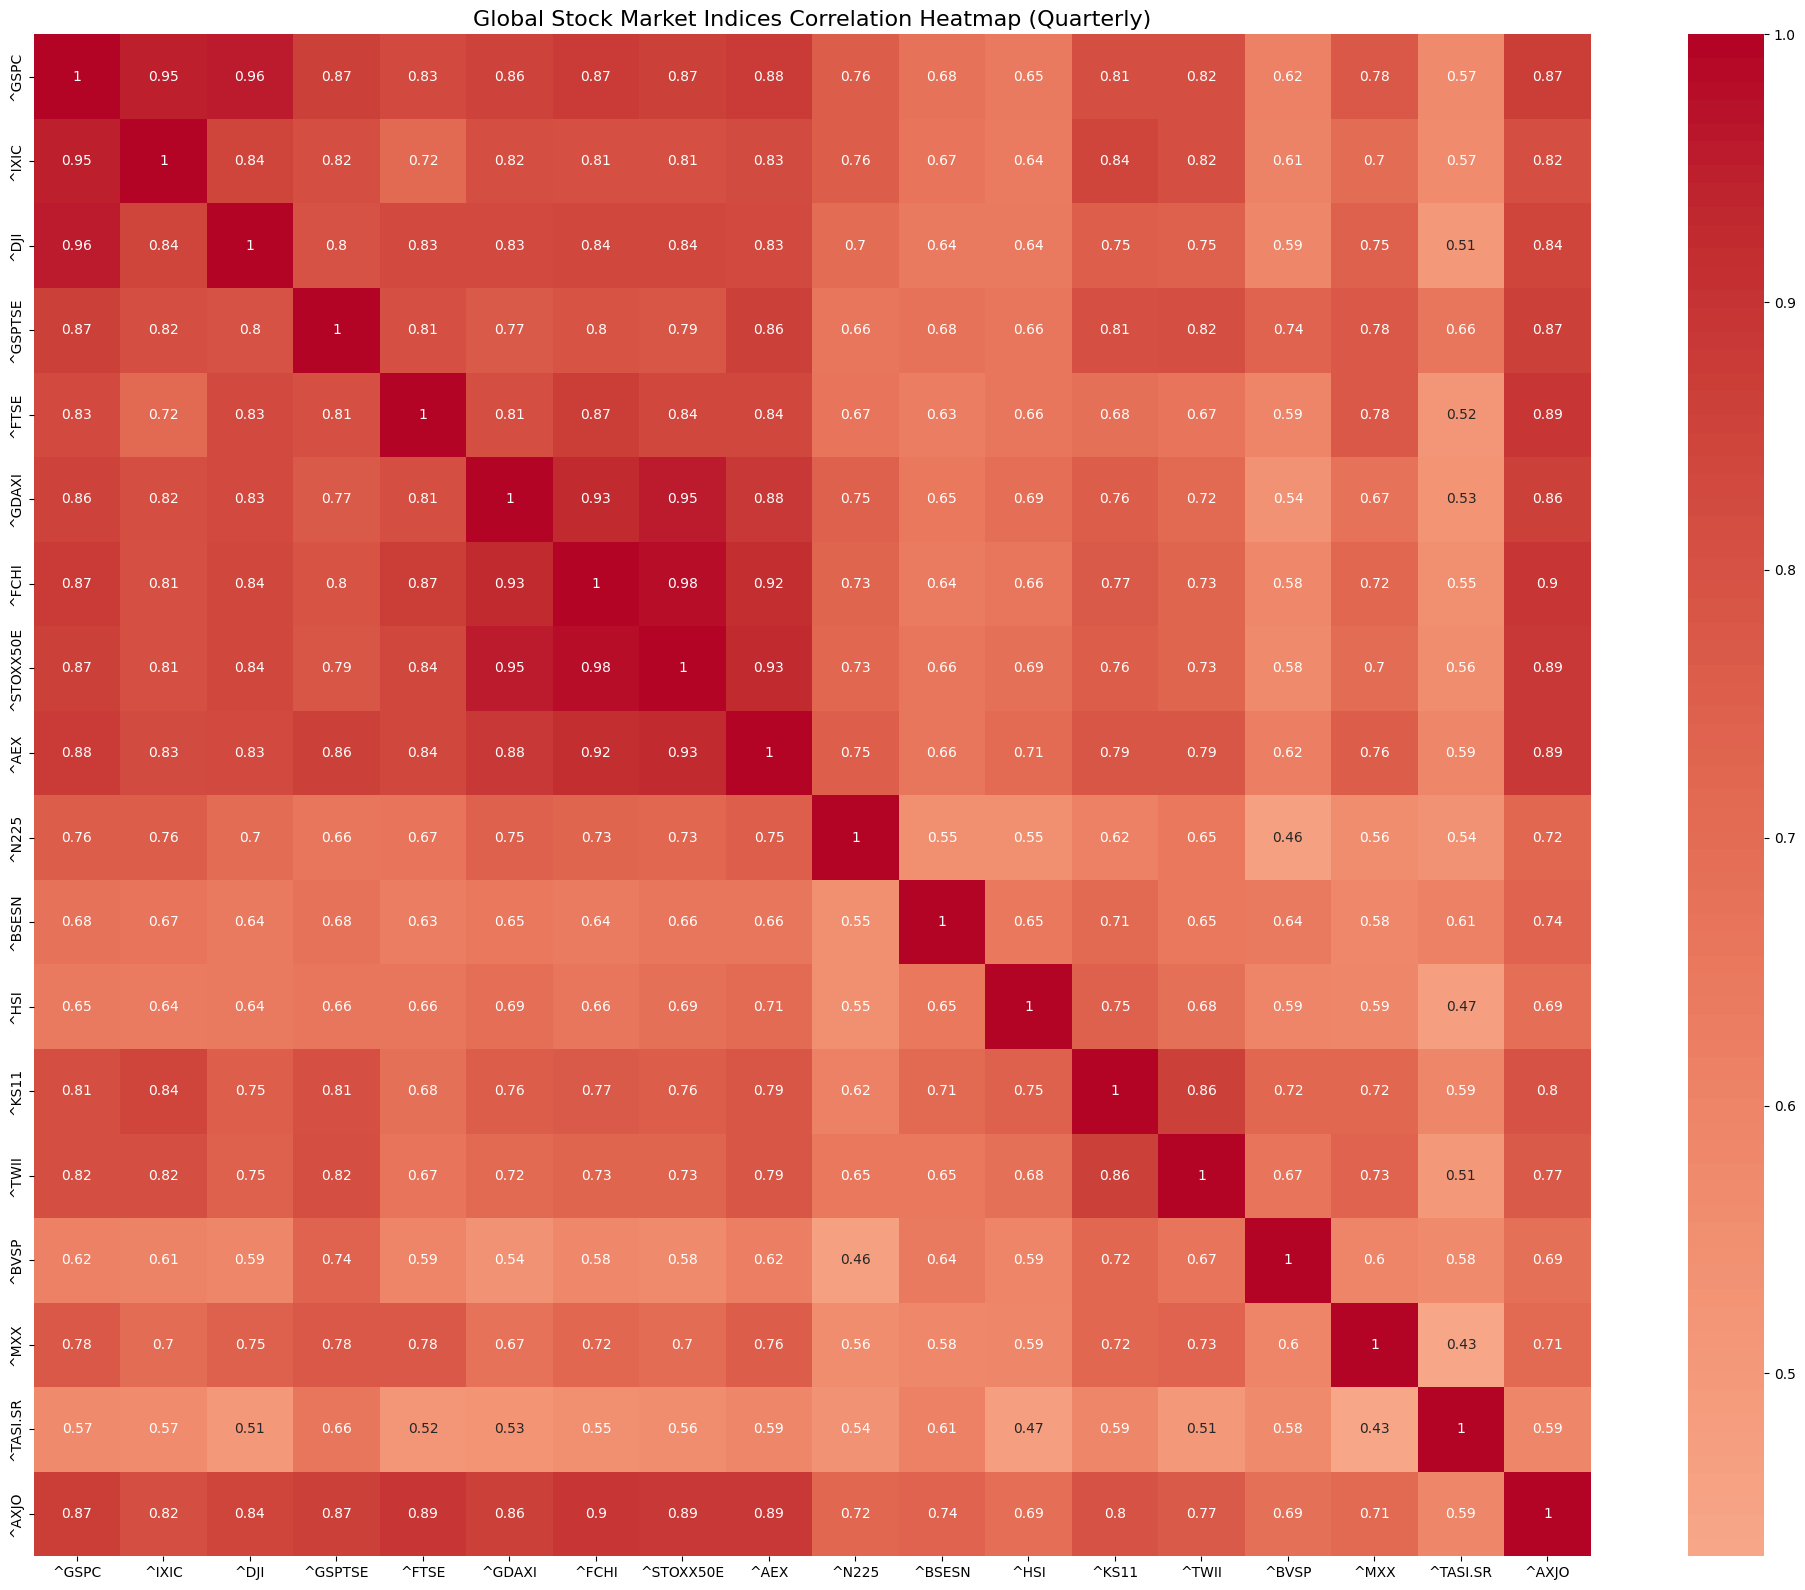

In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(
                        self.tickers[i], 
                        self.tickers[j], 
                        weight=corr
                    )
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_Weekly.png'):
        """
        Visualize the stock market network.
        
        Parameters:
        - output_file: File to save network visualization
        """
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color='lightblue', 
            node_size=node_sizes,
            alpha=0.7
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network Interconnectedness (Quarterly)', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()
    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='QE')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap (Quarterly)', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness  eigenvector
^AXJO      1.000000     0.005719     0.244842
^BSESN     1.000000     0.005719     0.244842
^TASI.SR   1.000000     0.005719     0.244842
^GSPTSE    1.000000     0.005719     0.244842
^FTSE      1.000000     0.005719     0.244842
^TWII      1.000000     0.005719     0.244842
^KS11      1.000000     0.005719     0.244842
^AEX       1.000000     0.005719     0.244842
^HSI       1.000000     0.005719     0.244842
^MXX       0.941176     0.004412     0.231935
^GSPC      0.941176     0.000490     0.236160
^IXIC      0.941176     0.000490     0.236160
^STOXX50E  0.941176     0.000490     0.236160
^FCHI      0.941176     0.000490     0.236160
^GDAXI     0.941176     0.000490     0.236160
^DJI       0.941176     0.000490     0.236160
^N225      0.882353     0.000000     0.222719
^BVSP      0.588235     0.000000     0.149822

Community Memberships:
Community 0: ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^FCHI

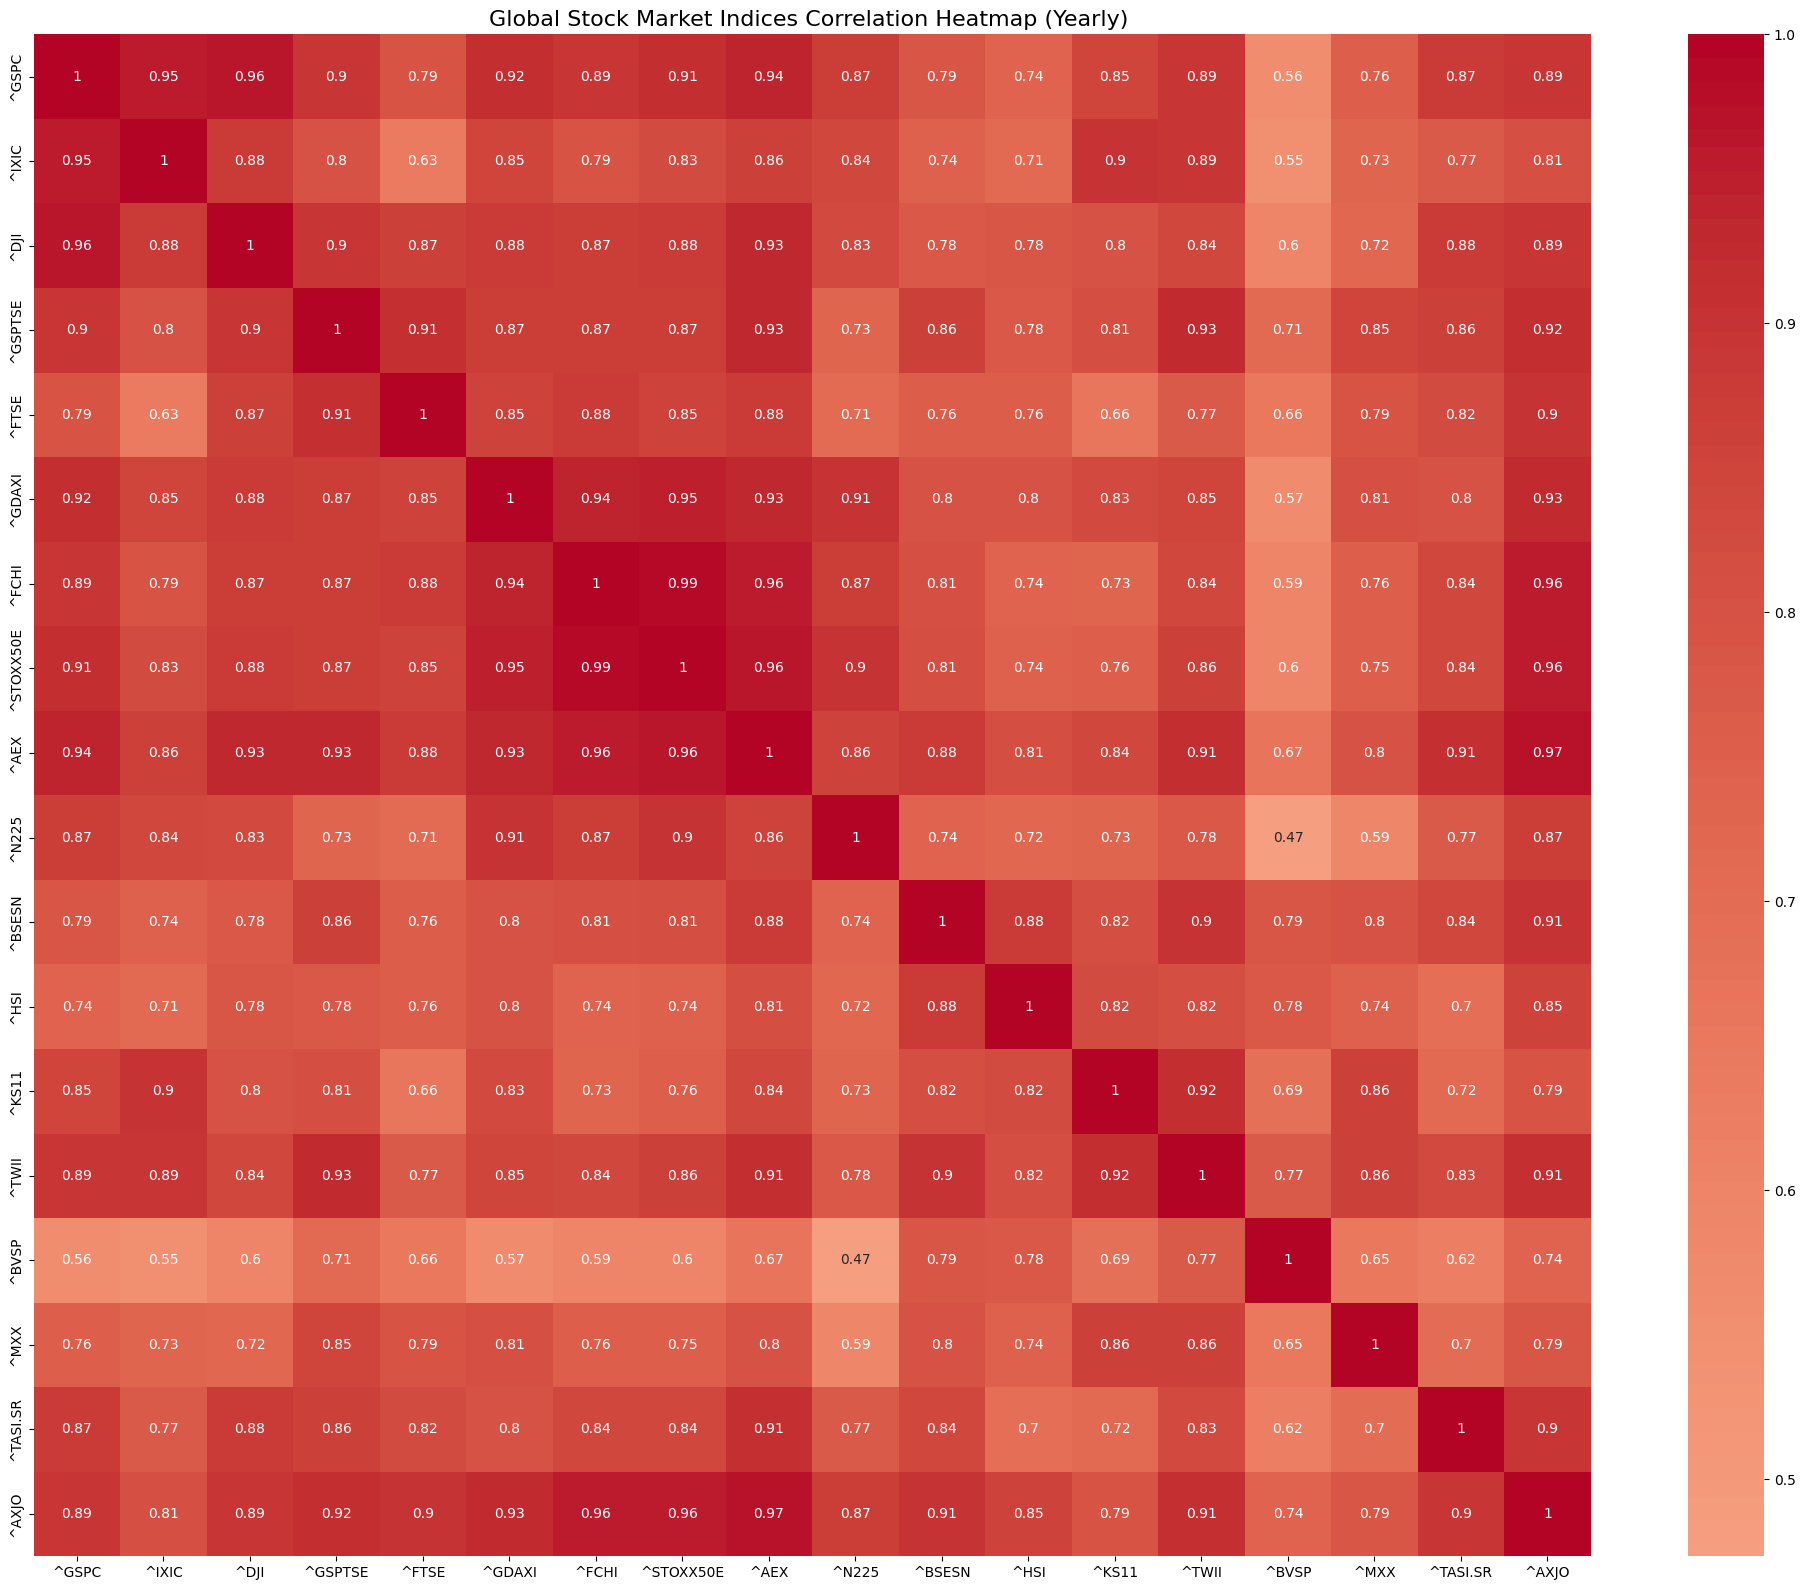

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(
                        self.tickers[i], 
                        self.tickers[j], 
                        weight=corr
                    )
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_yearly.png'):
        """
        Visualize the stock market network with community-based coloring.
        
        Parameters:
        - output_file: File to save network visualization
        """
        # Detect communities
        communities = self.detect_communities()

        if not communities:
            print("No communities detected.")
            return
        
        # Generate a color map for communities using light colors
        unique_communities = set(communities.values())
        light_colors = sns.color_palette("pastel", len(unique_communities))
        community_colors = {comm: light_colors[i] for i, comm in enumerate(unique_communities)}

        # Assign colors to nodes based on their community
        node_colors = [community_colors[communities[node]] for node in self.network.nodes()]

        # Create the network visualization
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes with colors based on community membership
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color=node_colors, 
            node_size=node_sizes,
            alpha=0.8
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network with Community-Based Coloring', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()

    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='YE')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap (Yearly) ', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness  eigenvector
^AEX       0.764706     0.150330     0.309795
^AXJO      0.705882     0.054742     0.304697
^FCHI      0.705882     0.054742     0.304697
^DJI       0.705882     0.041290     0.300656
^IXIC      0.705882     0.041290     0.300656
^STOXX50E  0.647059     0.042091     0.288737
^GSPC      0.647059     0.006127     0.294218
^GDAXI     0.588235     0.000000     0.278258
^FTSE      0.588235     0.000000     0.278258
^TASI.SR   0.588235     0.000000     0.278258
^N225      0.588235     0.000000     0.278258
^MXX       0.470588     0.063254     0.184486
^GSPTSE    0.352941     0.215290     0.121131
^BSESN     0.235294     0.103733     0.058920
^HSI       0.176471     0.000000     0.074417
^TWII      0.176471     0.127451     0.012219
^BVSP      0.117647     0.011425     0.006737
^KS11      0.058824     0.000000     0.001157

Community Memberships:
Community 0: ['^GSPC', '^IXIC', '^DJI', '^FTSE', '^GDAXI', '^FCHI

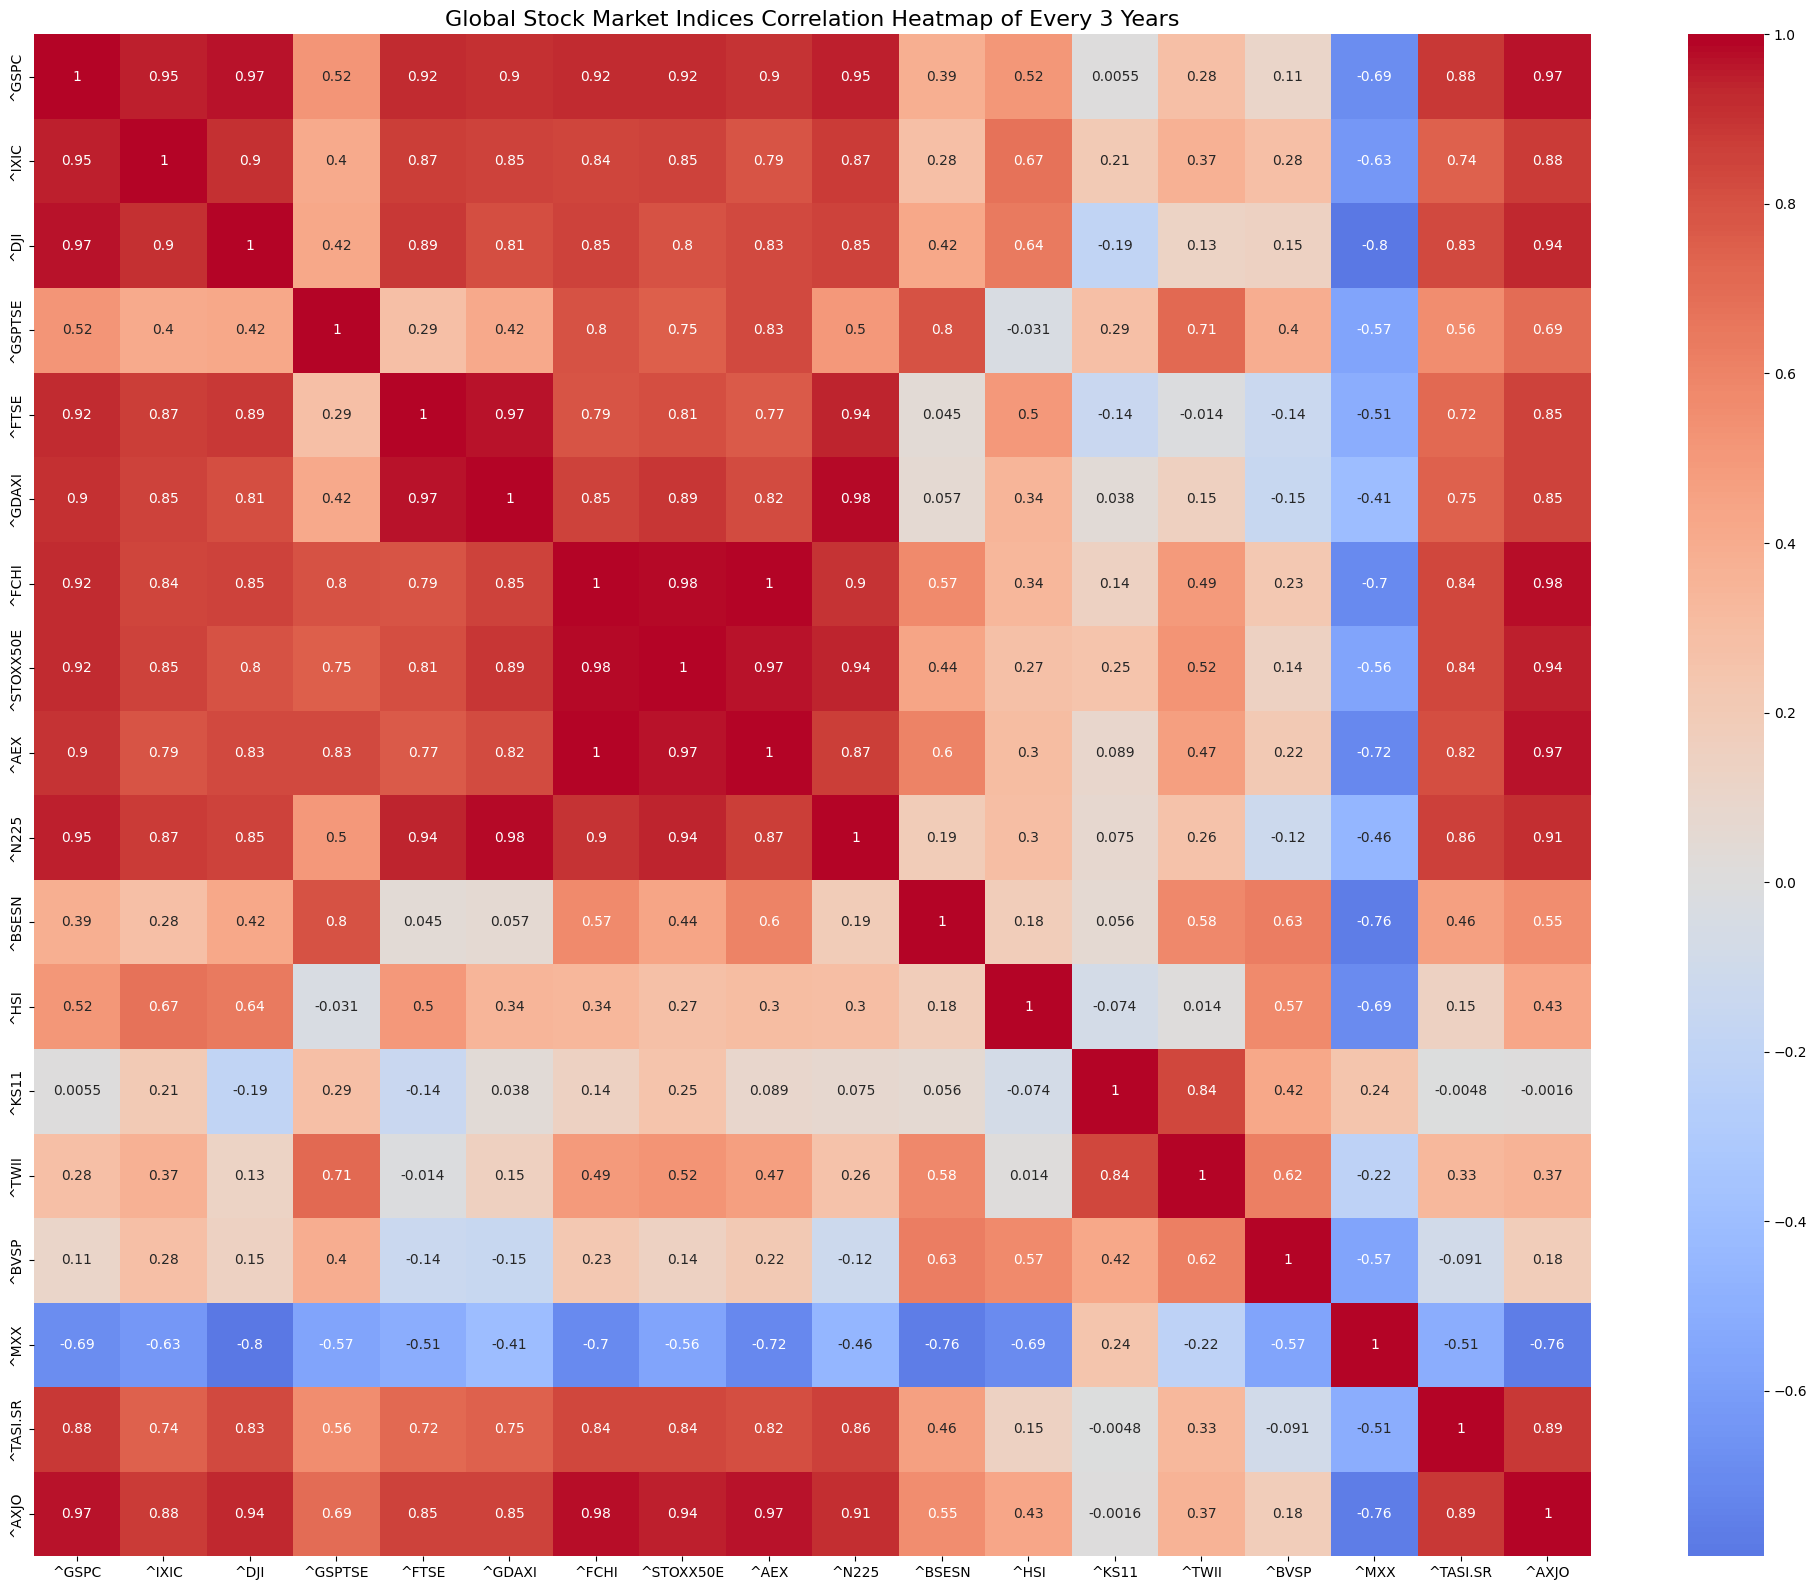

In [47]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(self.tickers[i], self.tickers[j], weight=abs(corr))
    
        # Check for isolated nodes and remove them
        isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
        G.remove_nodes_from(isolated_nodes)
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_3_Year.png'):
        """
        Visualize the stock market network.
        
        Parameters:
        - output_file: File to save network visualization
        """
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color='lightblue', 
            node_size=node_sizes,
            alpha=0.7
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network Interconnectedness of Every 3 Years', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()
    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='3YE')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap of Every 3 Years', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
              degree  betweenness  eigenvector
^GSPC      0.882353     0.013209     0.271085
^FCHI      0.882353     0.013209     0.271085
^TWII      0.882353     0.013209     0.271085
^AEX       0.882353     0.013209     0.271085
^STOXX50E  0.882353     0.013209     0.271085
^N225      0.882353     0.065878     0.252995
^GSPTSE    0.882353     0.013209     0.271085
^DJI       0.882353     0.037881     0.263258
^AXJO      0.882353     0.013209     0.271085
^GDAXI     0.764706     0.035485     0.222351
^FTSE      0.764706     0.035485     0.222351
^IXIC      0.764706     0.014216     0.234858
^BSESN     0.764706     0.005135     0.240602
^BVSP      0.647059     0.000668     0.207162
^MXX       0.647059     0.000668     0.207162
^TASI.SR   0.647059     0.002015     0.206458
^HSI       0.352941     0.004221     0.092279
^KS11      0.235294     0.000000     0.058135

Community Memberships:
Community 0: ['^GSPC', '^GSPTSE', '^FCHI', '^STOXX50E', '^AEX', '

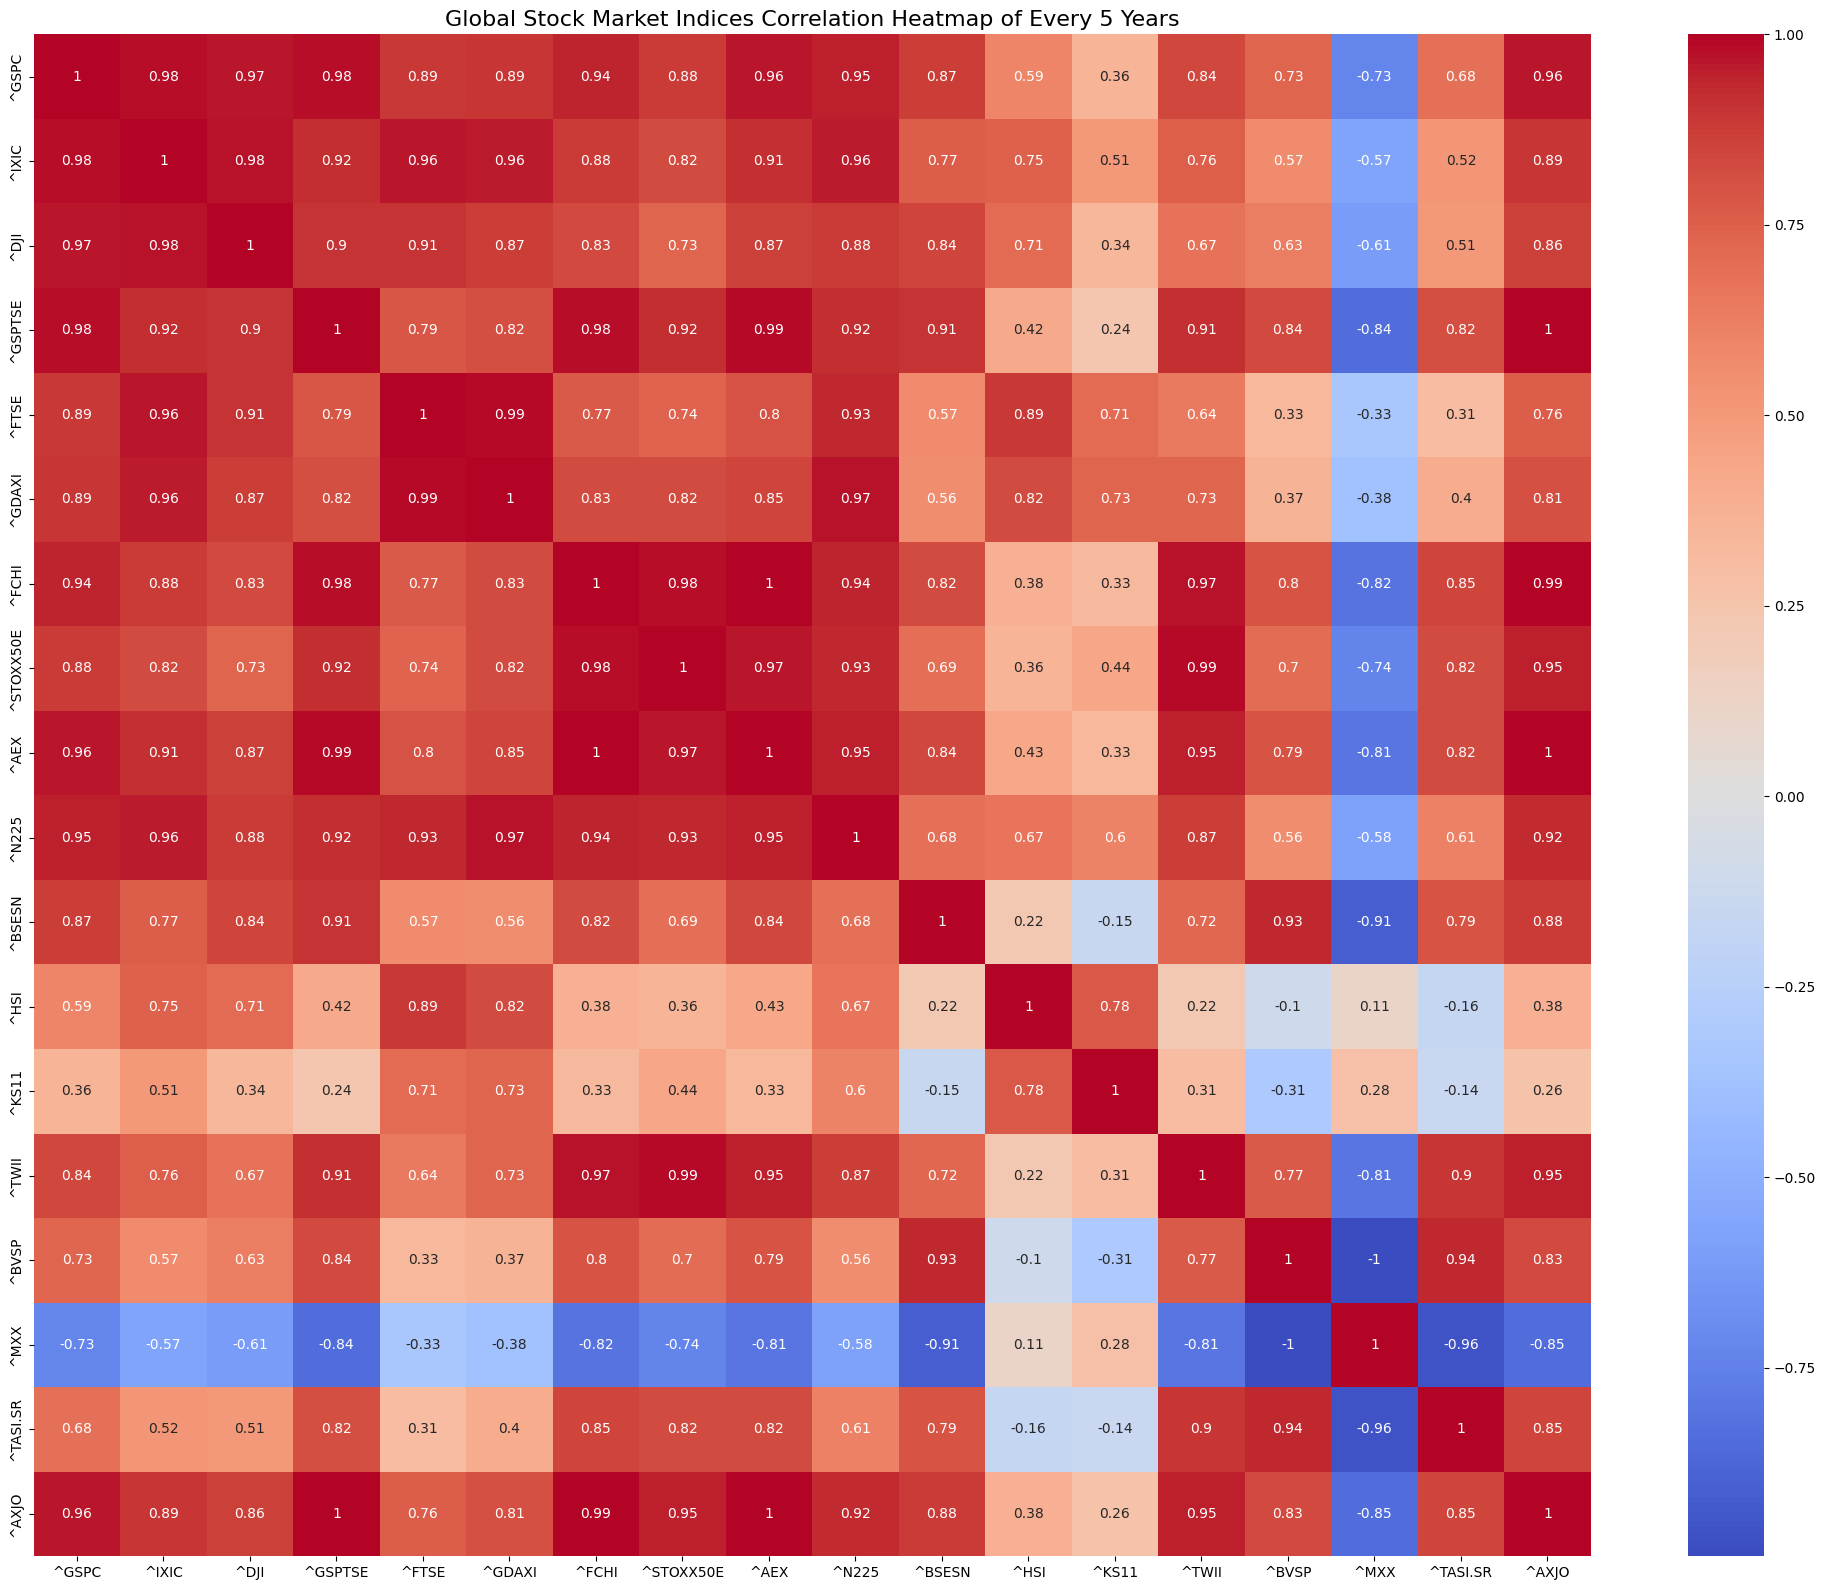

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(self.tickers[i], self.tickers[j], weight=abs(corr))
    
        # Check for isolated nodes and remove them
        isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
        G.remove_nodes_from(isolated_nodes)
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_of_Every_5_Year.png'):
        """
        Visualize the stock market network with community-based coloring.
        
        Parameters:
        - output_file: File to save network visualization
        """
        # Detect communities
        communities = self.detect_communities()

        if not communities:
            print("No communities detected.")
            return
        
        # Generate a color map for communities using light colors
        unique_communities = set(communities.values())
        light_colors = sns.color_palette("pastel", len(unique_communities))
        community_colors = {comm: light_colors[i] for i, comm in enumerate(unique_communities)}

        # Assign colors to nodes based on their community
        node_colors = [community_colors[communities[node]] for node in self.network.nodes()]

        # Create the network visualization
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes with colors based on community membership
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color=node_colors, 
            node_size=node_sizes,
            alpha=0.8
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network with Community-Based Coloring', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()

    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='5YE')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap of Every 5 Years', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Top Markets by Centrality Measures:
            degree  betweenness  eigenvector
^GSPC         1.0          0.0     0.235702
^IXIC         1.0          0.0     0.235702
^TASI.SR      1.0          0.0     0.235702
^MXX          1.0          0.0     0.235702
^BVSP         1.0          0.0     0.235702
^TWII         1.0          0.0     0.235702
^KS11         1.0          0.0     0.235702
^HSI          1.0          0.0     0.235702
^BSESN        1.0          0.0     0.235702
^N225         1.0          0.0     0.235702
^AEX          1.0          0.0     0.235702
^STOXX50E     1.0          0.0     0.235702
^FCHI         1.0          0.0     0.235702
^GDAXI        1.0          0.0     0.235702
^FTSE         1.0          0.0     0.235702
^GSPTSE       1.0          0.0     0.235702
^DJI          1.0          0.0     0.235702
^AXJO         1.0          0.0     0.235702

Community Memberships:
Community 0: ['^GSPC', '^IXIC', '^DJI', '^GSPTSE', '^FTSE', '^GDAXI', '^FCHI', '^STOXX50E', '^AEX', '^N

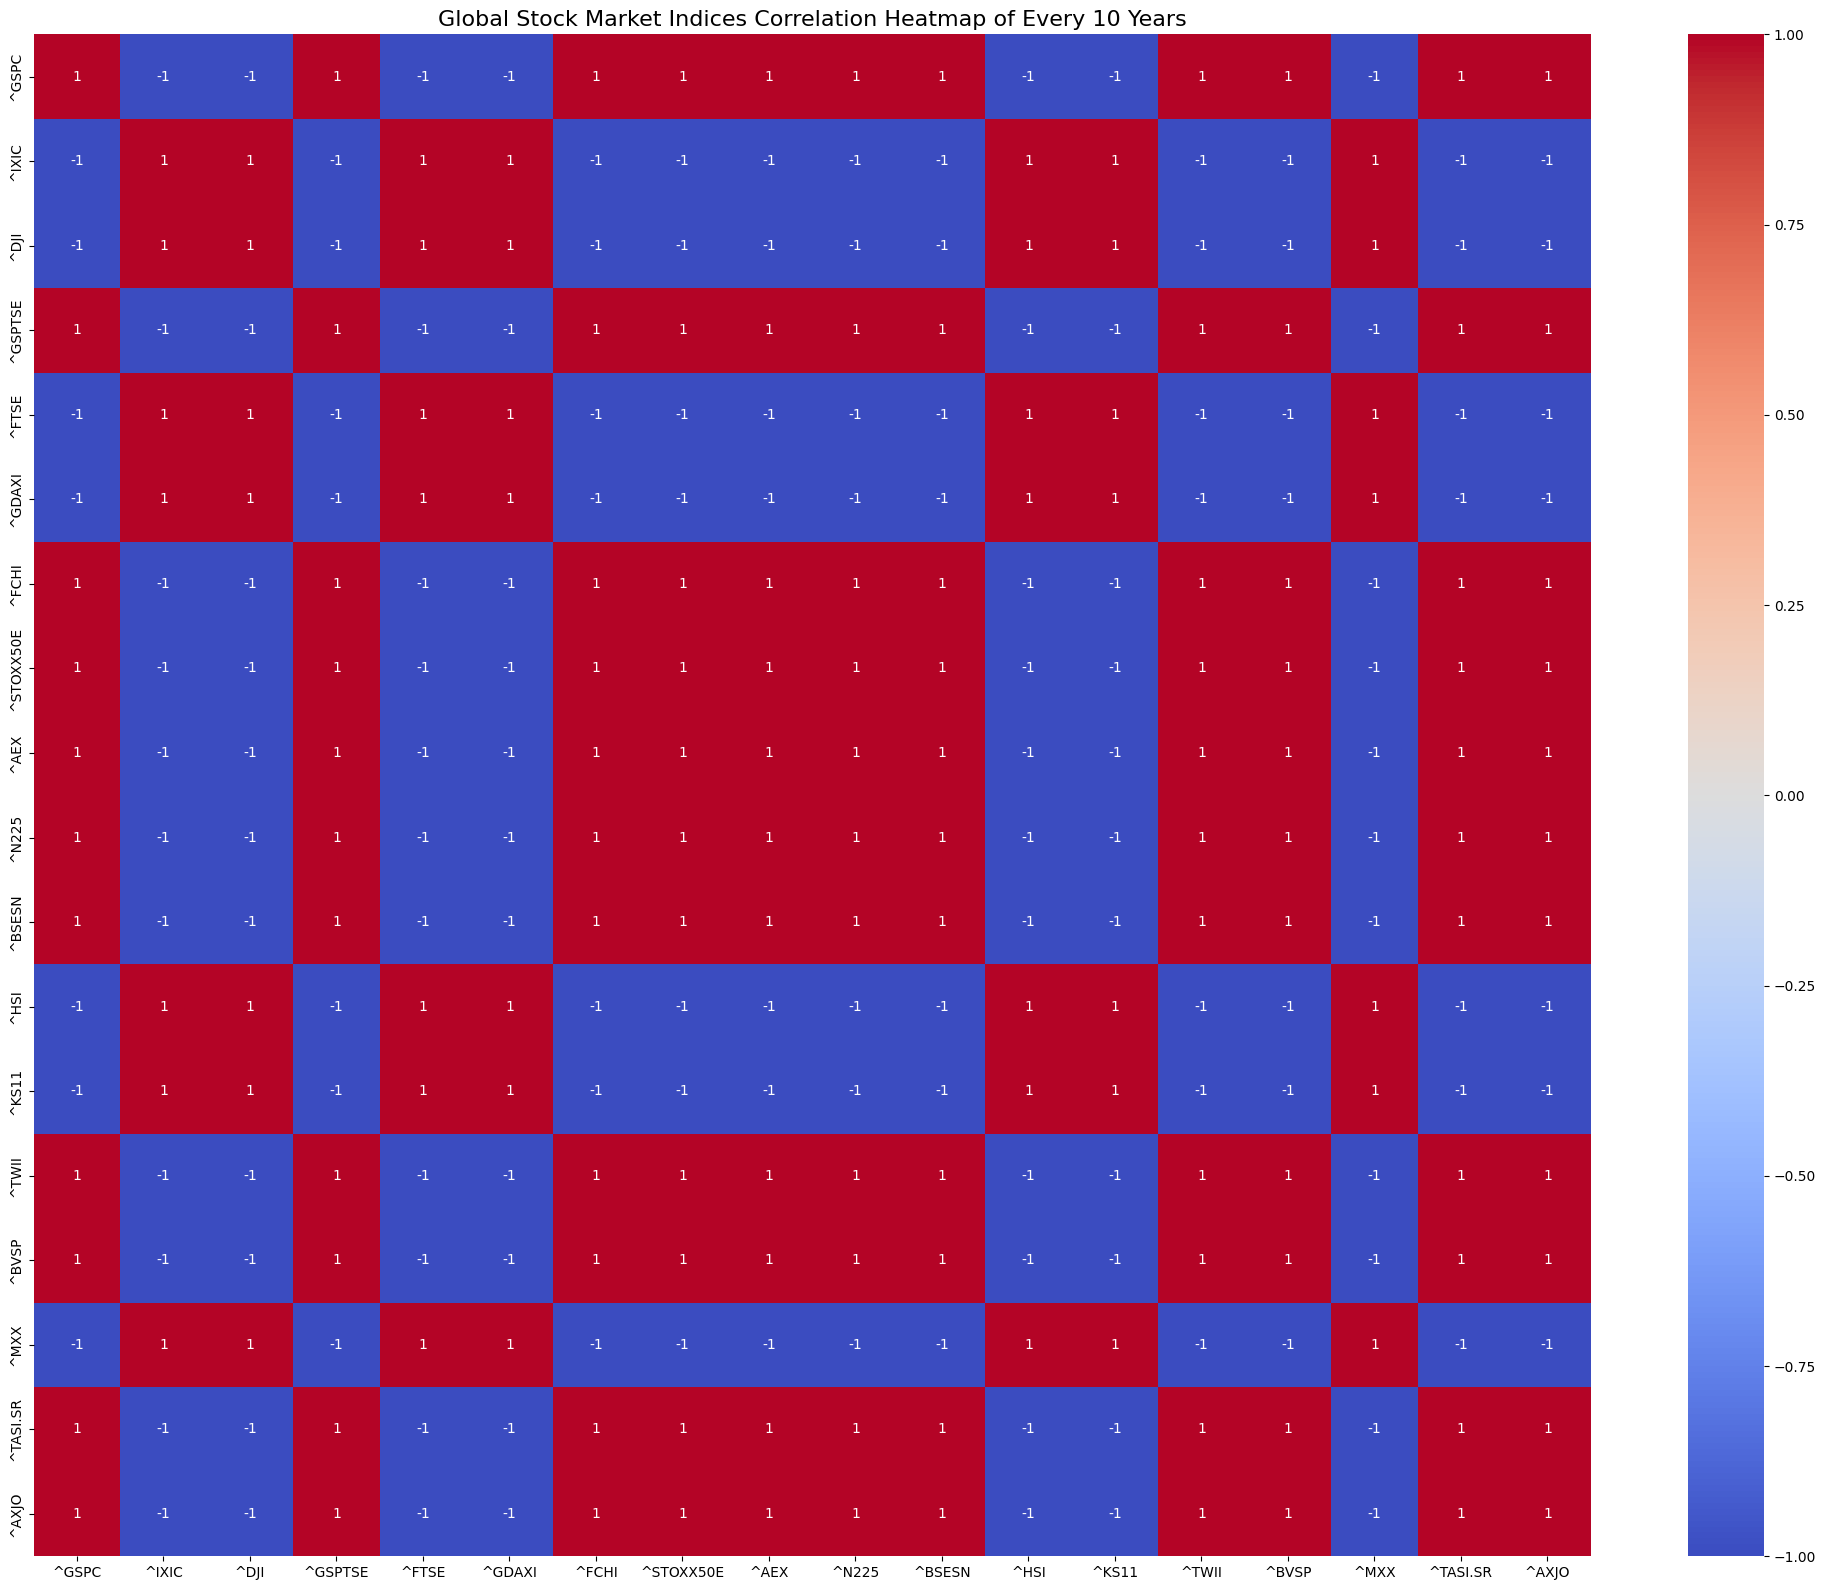

In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

class GlobalStockMarketNetworkAnalysis:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the global stock market network analysis.
        
        Parameters:
        - tickers: List of global stock market index tickers
        - start_date: Start date for data collection
        - end_date: End date for data collection
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.correlation_matrix = None
        self.network = None
    
    def fetch_data(self, resample=None):
        """
        Fetch stock market index data using yfinance.
        
        Parameters:
        - resample: Resample frequency
        """
        data_dict = {}
        for ticker in self.tickers:
            try:
                df = yf.download(ticker, start=self.start_date, end=self.end_date)['Close']
                
                # Resample if specified
                if resample:
                    df = df.resample(resample).last()
                
                data_dict[ticker] = df
            except Exception as e:
                print(f"Could not fetch data for {ticker}: {e}")
        
        self.data = pd.DataFrame(data_dict)
        return self.data
    
    def calculate_returns(self, method='log'):
        """
        Calculate returns for the stock market indices.
        
        Parameters:
        - method: 'log' or 'simple' return calculation
        """
        if method == 'log':
            self.returns = np.log(self.data / self.data.shift(1)).dropna()
        else:
            self.returns = (self.data / self.data.shift(1) - 1).dropna()
        
        return self.returns
    
    def compute_correlation_matrix(self, method='pearson'):
        """
        Compute correlation matrix for returns.
        
        Parameters:
        - method: Correlation method ('pearson', 'spearman')
        """
        if method == 'pearson':
            self.correlation_matrix = self.returns.corr()
        else:
            self.correlation_matrix = self.returns.corr(method='spearman')
        
        # Filter tickers to match correlation matrix columns
        self.tickers = self.correlation_matrix.columns.tolist()
        return self.correlation_matrix

    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i, ticker_i in enumerate(self.tickers):
            for j, ticker_j in enumerate(self.tickers):
                if i < j:  # Avoid duplicate pairs
                    corr = self.correlation_matrix.iloc[i, j]
                    if abs(corr) >= threshold:
                        G.add_edge(ticker_i, ticker_j, weight=corr)
        
        self.network = G
        return G

    
    def create_network(self, threshold=0.7):
        """
        Create a network based on correlation matrix.
        
        Parameters:
        - threshold: Correlation threshold for edge creation
        """
        # Create graph
        G = nx.Graph()
        
        # Add nodes
        G.add_nodes_from(self.tickers)
        
        # Add edges based on correlation
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                corr = self.correlation_matrix.iloc[i, j]
                if abs(corr) >= threshold:
                    G.add_edge(self.tickers[i], self.tickers[j], weight=abs(corr))
    
        # Check for isolated nodes and remove them
        isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
        G.remove_nodes_from(isolated_nodes)
        
        self.network = G
        return G
    
    def compute_centrality_measures(self):
        """
        Compute centrality measures for the network.
        """
        if not self.network:
            raise ValueError("Network not created. Run create_network() first.")
        
        centrality_measures = {
            'degree': nx.degree_centrality(self.network),
            'betweenness': nx.betweenness_centrality(self.network),
            'eigenvector': nx.eigenvector_centrality(self.network)
        }
        
        # Convert to DataFrame with readable index
        centrality_df = pd.DataFrame(centrality_measures, index=list(centrality_measures['degree'].keys()))
        
        # Sort by degree centrality to highlight most connected markets
        return centrality_df.sort_values('degree', ascending=False)
    
    def detect_communities(self, method='louvain'):
        """
        Detect communities in the network.
        
        Parameters:
        - method: Community detection method
        """
        try:
            import community as community_louvain
        except ImportError:
            print("Please install python-louvain: pip install python-louvain")
            return None
        
        if method == 'louvain':
            partition = community_louvain.best_partition(self.network)
            return partition
        
        return None
    
    def visualize_network(self, output_file='global_stock_market_network_10_Year.png'):
        """
        Visualize the stock market network.
        
        Parameters:
        - output_file: File to save network visualization
        """
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(self.network, k=0.5, iterations=50, seed=42)
        
        # Node sizes based on degree centrality
        degrees = dict(self.network.degree())
        node_sizes = [300 * (degrees.get(node, 0) + 1) for node in self.network.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(
            self.network, 
            pos, 
            node_color='lightblue', 
            node_size=node_sizes,
            alpha=0.7
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            self.network, 
            pos, 
            alpha=0.3,
            width=[self.network[u][v]['weight'] * 2 for u, v in self.network.edges()]
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            self.network, 
            pos, 
            font_size=8, 
            font_weight='bold'
        )
        
        plt.title('Global Stock Market Network Interconnectedness of Every 10 Years', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()
    
    def comprehensive_analysis(self):
        """
        Perform comprehensive network analysis.
        """
        # Compute centrality measures
        centrality = self.compute_centrality_measures()
        print("Top Markets by Centrality Measures:\n", centrality)
        
        # Detect communities
        communities = self.detect_communities()
        if communities:
            print("\nCommunity Memberships:")
            community_groups = {}
            for node, community in communities.items():
                if community not in community_groups:
                    community_groups[community] = []
                community_groups[community].append(node)
            
            for comm, markets in community_groups.items():
                print(f"Community {comm}: {markets}")
        
        return centrality, communities

def main():
    # Expanded list of global stock market indices
    tickers = [
        # North America
        '^GSPC',   # S&P 500 (USA)
        '^IXIC',   # NASDAQ Composite (USA)
        '^DJI',    # Dow Jones Industrial Average (USA)
        '^GSPTSE',    # S&P/TSX Composite (Canada)
        
        # Europe
        '^FTSE',   # FTSE 100 (UK)
        '^GDAXI',  # DAX (Germany)
        '^FCHI',   # CAC 40 (France)
        '^STOXX50E', # Euro Stoxx 50
        '^AEX',    # AEX (Netherlands)
        
        # Asia Pacific
        '^N225',   # Nikkei 225 (Japan)
        '^BSESN',   # SENSEX (India)
        '^HSI',    # Hang Seng (Hong Kong)
        # '^000001.SS',   # Shanghai Composite (China)
        '^KS11',  # KOSPI (South Korea)
        '^TWII',   # Taiwan Weighted Index
        
        # Latin America
        '^BVSP',   # Bovespa (Brazil)
        '^MXX',    # Mexico IPC
        
        # Middle East & Africa
        '^TASI.SR',   # Tadawul All Share (Saudi Arabia)
        
        # Oceania
        '^AXJO'    # ASX 200 (Australia)
    ]
    
    # Initialize and run analysis
    analysis = GlobalStockMarketNetworkAnalysis(
        tickers, 
        start_date='2007-04-01', 
        end_date='2024-03-31'
    )
    
    # Fetch monthly data for more stable analysis
    data = analysis.fetch_data(resample='10YE')
    
    # Calculate monthly returns
    returns = analysis.calculate_returns()
    
    # Compute correlation matrix
    correlation_matrix = analysis.compute_correlation_matrix()
    
    # Create network with slightly relaxed threshold
    network = analysis.create_network(threshold=0.6)
    
    # Perform comprehensive analysis
    centrality, communities = analysis.comprehensive_analysis()
    
    # Visualize network
    analysis.visualize_network()
    
    # Plot correlation heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                xticklabels=correlation_matrix.columns, 
                yticklabels=correlation_matrix.index)
    plt.title('Global Stock Market Indices Correlation Heatmap of Every 10 Years', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()